># ResNet50V2

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip '/content/drive/MyDrive/Dataset/data.zip'

Found 8320 images belonging to 38 classes.
Found 2059 images belonging to 38 classes.
94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/50
260/260 [==============================] - 145s 523ms/step - loss: 2.2887 - accuracy: 0.3692 - val_loss: 1.1802 - val_accuracy: 0.6440 - lr: 1.0000e-04
Epoch 2/50
260/260 [==============================] - 152s 586ms/step - loss: 0.8937 - accuracy: 0.7240 - val_loss: 1.0381 - val_accuracy: 0.6872 - lr: 1.0000e-04
Epoch 3/50
260/260 [==============================] - 136s 522ms/step - loss: 0.5967 - accuracy: 0.8171 - val_loss: 0.8975 - val_accuracy: 0.7397 - lr: 1.0000e-04
Epoch 4/50
260/260 [==============================] - 136s 524ms/step - loss: 0.4511 - accuracy: 0.8571 - val_loss: 0.8875 - val_accuracy: 0.7470 - lr: 1.0000e-04
Epoch 5/50
260/260 [==============================] - 136s 522ms/step - loss: 0.3624 - accuracy: 0.8861 - val_loss: 0.8264 - val_accuracy: 0.7586 - lr: 1.0000e-04
Epoch 6/50
260/260 [==============

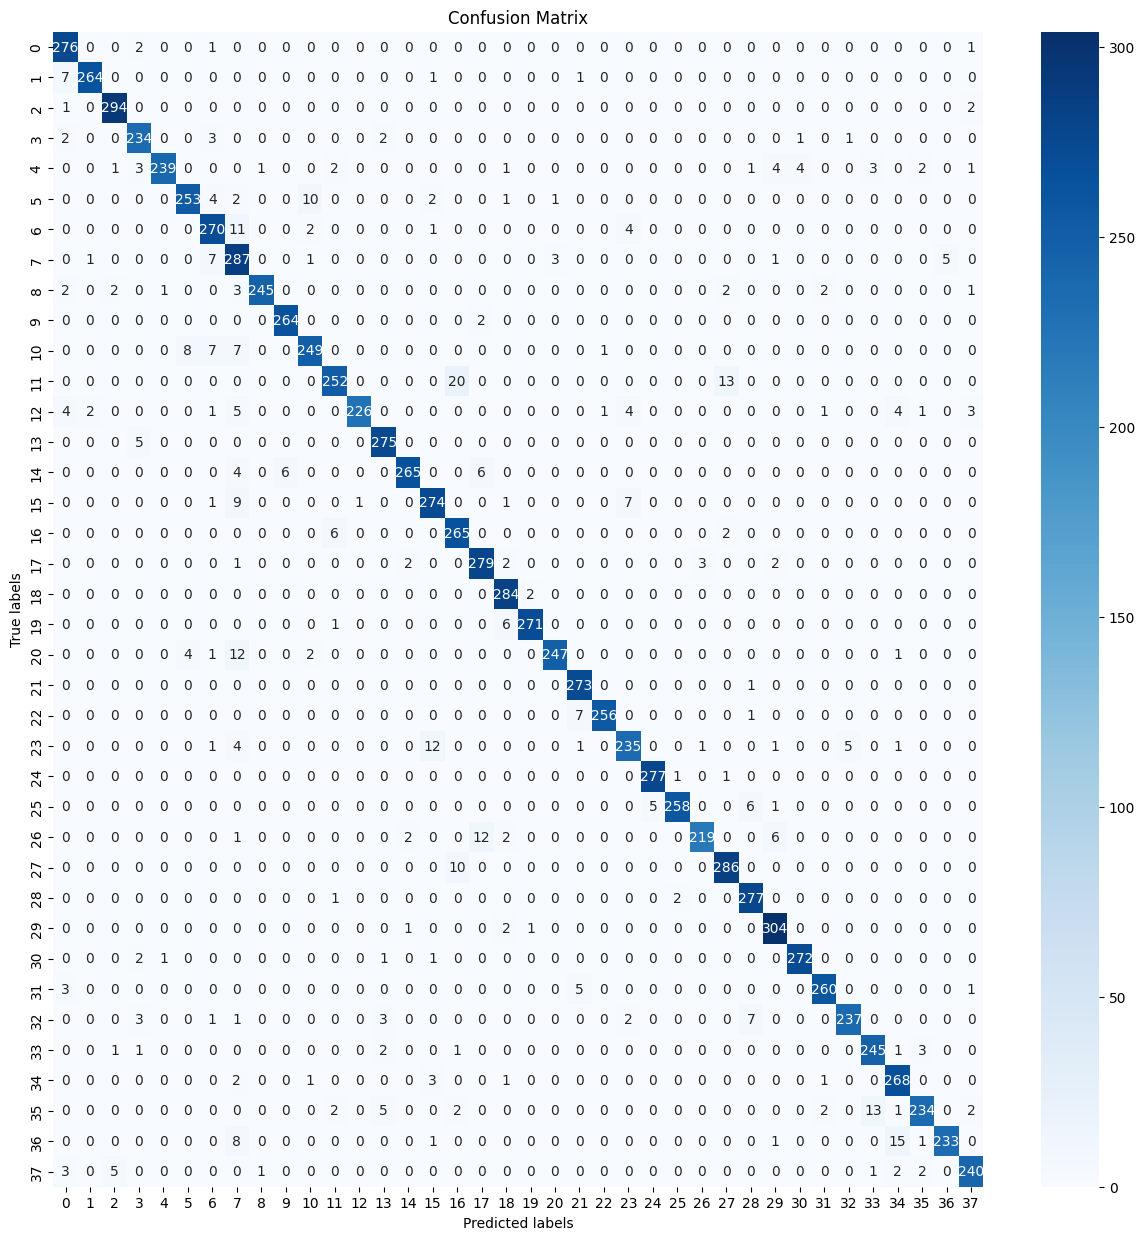

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       280
           1       0.99      0.97      0.98       273
           2       0.97      0.99      0.98       297
           3       0.94      0.96      0.95       243
           4       0.99      0.91      0.95       262
           5       0.95      0.93      0.94       273
           6       0.91      0.94      0.92       288
           7       0.80      0.94      0.87       305
           8       0.99      0.95      0.97       258
           9       0.98      0.99      0.99       266
          10       0.94      0.92      0.93       272
          11       0.95      0.88      0.92       285
          12       1.00      0.90      0.94       252
          13       0.95      0.98      0.97       280
          14       0.98      0.94      0.96       281
          15       0.93      0.94      0.93       293
          16       0.89      0.97      0.93       273
    

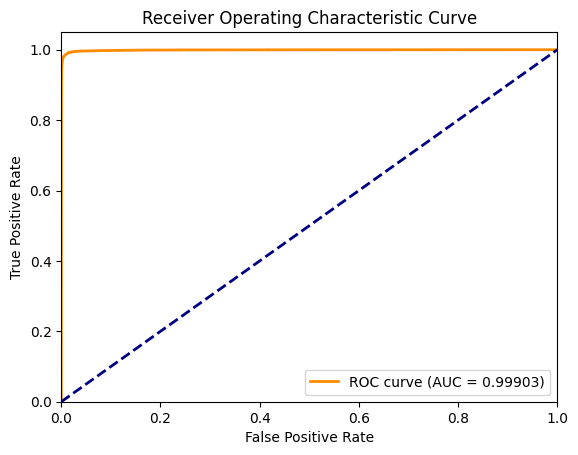

In [7]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define directories and parameters
folder_dir = '/content/data'
SIZE = 224
no_of_classes = 38
batch_size = 32
picture_size = (SIZE, SIZE)
epochs = 50

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,  # increased rotation range
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1./255
)

train_set = train_datagen.flow_from_directory(
    directory=folder_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=22
)

validation_set = train_datagen.flow_from_directory(
    directory=folder_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=22
)

# Model building
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(no_of_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning by unfreezing some layers
for layer in model.layers[:-20]:  # unfreeze last 20 layers
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # lower learning rate
    metrics=['accuracy']
)

# Training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
callbacks = [lr_scheduler, early_stopping]

history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=validation_set,
    callbacks=callbacks
)

# Evaluate on test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='/content/data',  # Update to your test data directory
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)

# Compute and display metrics
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred))

roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
